In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import joblib as jl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

root = 'dl'

# Load raw data

In [12]:
labels = pd.read_csv('../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
labels.head()

,CLASS
PIN,
568483,1
923748,0
2035328,0
2239386,1
2244533,1


In [13]:
data = jl.load(open('../tmp/labels__raw_data_.pkl', 'rb')).loc[labels.index, 'seq']
df = pd.DataFrame(columns=['Seq', 'Class'], index=data.index)
df.loc[:, 'Seq'] = data
df.loc[:, 'Class'] = labels['CLASS']
df.head()

,Seq,Class
PIN,,
568483,T0G1G0T0T0T0G0G1L0L0L0G0G0T0T1L0L0L0L0L0G0T0L0...,1
923748,P0P0P0L0E0I2T0G1L2T0T0G0S0H0P0P0P0T0G0S0T1L2D1...,0
2035328,P0P0P0H0P0P0P0P0O0O0G0E3G0I0G2G1E2H0P0P0P0P0P0...,0
2239386,T0G3P0P0P0H0P0D0E1G0G0G0T0G1E3H0P0P0P0T0G0I2T0...,1
2244533,T0G2G0T0P0P0P0H0G0T2T0G0P0P0P0I0I0P0G0T0T0G0T0...,1


# Seq2Tokens

In [16]:
# Define tokenizer object
tokenizer = Tokenizer(char_level=True, lower=False, split='')

# Fit on corpus and extract tokenized sequences
tokenizer.fit_on_texts(df['Seq'])
n_feat = len(tokenizer.word_index.keys())
seq = tokenizer.texts_to_sequences(df['Seq'])

# Pad tokenized sequences
lengths = [len(x) for x in seq]
maxlen = int(np.percentile(lengths, 90))
p_seq = pad_sequences(seq, maxlen=maxlen)
print(p_seq.shape)

(11744, 701)


# Training - Validation - Test split

In [24]:
# Full dataset
y = df['Class'].ravel()
X = p_seq

# Learn / Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
learn_idx, test_idx = next(sss.split(X, y))

X_learn, y_learn = X[learn_idx, :], y[learn_idx]
X_test, y_test = X[test_idx, :], y[test_idx]

print('{} learn / {} test'.format(len(y_learn), len(y_test)))

# Training / Validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
train_idx, valid_idx = next(sss.split(X_learn, y_learn))

X_train, y_train = X_learn[train_idx, :], y_learn[train_idx]
X_valid, y_valid = X_learn[valid_idx, :], y_learn[valid_idx]

print('{} training / {} validation'.format(len(y_train), len(y_valid)))

5872 learn / 5872 test
5284 training / 588 validation


# Model \#1: Embedding + Dense (overfitting like crazy)

In [25]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 701, 64)           1088      
_________________________________________________________________
flatten_2 (Flatten)          (None, 44864)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 44865     
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [26]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/500
5284/5284 [==============================] - 1s 95us/step - loss: 0.6975 - acc: 0.5473 - val_loss: 0.6995 - val_acc: 0.5051
Epoch 2/500
5284/5284 [==============================] - 0s 67us/step - loss: 0.6381 - acc: 0.6558 - val_loss: 0.6329 - val_acc: 0.6241
Epoch 3/500
5284/5284 [==============================] - 0s 67us/step - loss: 0.5936 - acc: 0.6947 - val_loss: 0.6148 - val_acc: 0.6565
Epoch 4/500
5284/5284 [==============================] - 0s 66us/step - loss: 0.5612 - acc: 0.7248 - val_loss: 0.6087 - val_acc: 0.6684
Epoch 5/500
5284/5284 [==============================] - 0s 66us/step - loss: 0.5322 - acc: 0.7445 - val_loss: 0.6128 - val_acc: 0.6973
Epoch 6/500
5284/5284 [==============================] - 0s 64us/step - loss: 0.5090 - acc: 0.7572 - val_loss: 0.6149 - val_acc: 0.6820
Epoch 7/500
5284/5284 [==============================] - 0s 65us/step - loss: 0.4829 - acc: 0.7718 - val_loss: 0.6297 - val_acc: 0.6684
E

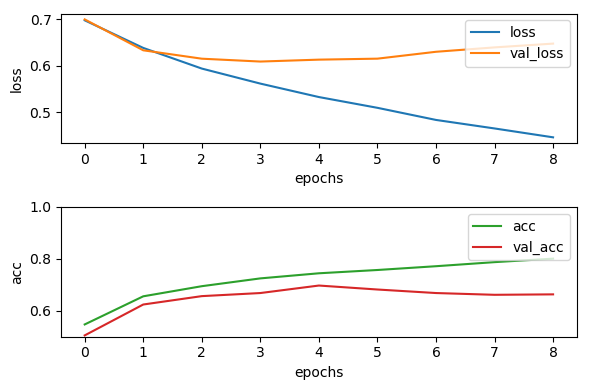

In [27]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_dense.png')

In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 1s 92us/step
test_loss: 0.6714 - test_acc: 0.6485


In [29]:
# model.save_weights('embedding_dense.h5')

# Model \#2: Embedding + SimpleRNN

In [30]:
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 701, 64)           1088      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/30
5284/5284 [==============================] - 13s 2ms/step - loss: 0.6542 - acc: 0.6192 - val_loss: 0.6230 - val_acc: 0.6667
Epoch 2/30
5284/5284 [==============================] - 12s 2ms/step - loss: 0.6248 - acc: 0.6605 - val_loss: 0.6134 - val_acc: 0.6684
Epoch 3/30
5284/5284 [==============================] - 13s 2ms/step - loss: 0.6125 - acc: 0.6637 - val_loss: 0.6102 - val_acc: 0.6871
Epoch 4/30
5284/5284 [==============================] - 13s 2ms/step - loss: 0.6058 - acc: 0.6762 - val_loss: 0.6256 - val_acc: 0.6599
Epoch 5/30
5284/5284 [==============================] - 12s 2ms/step - loss: 0.6020 - acc: 0.6775 - val_loss: 0.6035 - val_acc: 0.6803
Epoch 6/30
5284/5284 [==============================] - 12s 2ms/step - loss: 0.6009 - acc: 0.6860 - val_loss: 0.5931 - val_acc: 0.6939
Epoch 7/30
5284/5284 [==============================] - 12s 2ms/step - loss: 0.5971 - acc: 0.6900 - val_loss: 0.6208 - val_acc: 0.6769
Epoch 8/

# Model \#3: Embedding + LSTM

In [33]:
from keras.layers import CuDNNLSTM

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 701, 64)           1088      
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,665
Trainable params: 13,665
Non-trainable params: 0
_________________________________________________________________


In [34]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 5s 1ms/step - loss: 0.6854 - acc: 0.5698 - val_loss: 0.6473 - val_acc: 0.6633
Epoch 2/300
5284/5284 [==============================] - 4s 669us/step - loss: 0.6502 - acc: 0.6383 - val_loss: 0.6072 - val_acc: 0.6650
Epoch 3/300
5284/5284 [==============================] - 4s 670us/step - loss: 0.6075 - acc: 0.6760 - val_loss: 0.5889 - val_acc: 0.6922
Epoch 4/300
5284/5284 [==============================] - 4s 677us/step - loss: 0.5997 - acc: 0.6841 - val_loss: 0.6002 - val_acc: 0.6888
Epoch 5/300
5284/5284 [==============================] - 4s 674us/step - loss: 0.5947 - acc: 0.6832 - val_loss: 0.5919 - val_acc: 0.6956
Epoch 6/300
5284/5284 [==============================] - 4s 674us/step - loss: 0.5933 - acc: 0.6896 - val_loss: 0.5843 - val_acc: 0.6905
Epoch 7/300
5284/5284 [==============================] - 4s 672us/step - loss: 0.5888 - acc: 0.6887 - val_loss: 0.5731 - val_acc: 0.7

5284/5284 [==============================] - 3s 642us/step - loss: 0.5694 - acc: 0.7036 - val_loss: 0.5788 - val_acc: 0.7007
Epoch 61/300
5284/5284 [==============================] - 3s 634us/step - loss: 0.5663 - acc: 0.7101 - val_loss: 0.5722 - val_acc: 0.7126
Epoch 62/300
5284/5284 [==============================] - 3s 636us/step - loss: 0.5638 - acc: 0.7121 - val_loss: 0.5646 - val_acc: 0.7109
Epoch 63/300
5284/5284 [==============================] - 3s 634us/step - loss: 0.5658 - acc: 0.7127 - val_loss: 0.5677 - val_acc: 0.7007
Epoch 64/300
5284/5284 [==============================] - 3s 632us/step - loss: 0.5605 - acc: 0.7125 - val_loss: 0.5619 - val_acc: 0.7092
Epoch 65/300
5284/5284 [==============================] - 3s 635us/step - loss: 0.5573 - acc: 0.7154 - val_loss: 0.5636 - val_acc: 0.7245
Epoch 66/300
5284/5284 [==============================] - 3s 631us/step - loss: 0.5625 - acc: 0.7076 - val_loss: 0.5605 - val_acc: 0.7092
Epoch 67/300
5284/5284 [=======================

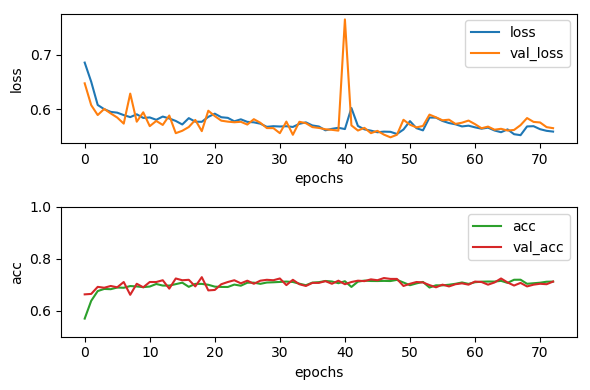

In [35]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_LSTM.png')

# Model \#4: Embedding + Conv1D + LSTM

In [36]:
from keras.layers import Conv1D

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 701, 64)           1088      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 697, 64)           20544     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
_________________________________________________________________


In [37]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 5s 872us/step - loss: 0.6592 - acc: 0.6183 - val_loss: 0.6274 - val_acc: 0.6480
Epoch 2/300
5284/5284 [==============================] - 4s 751us/step - loss: 0.6266 - acc: 0.6593 - val_loss: 0.6158 - val_acc: 0.6803
Epoch 3/300
5284/5284 [==============================] - 4s 758us/step - loss: 0.6120 - acc: 0.6745 - val_loss: 0.6254 - val_acc: 0.6735
Epoch 4/300
5284/5284 [==============================] - 4s 762us/step - loss: 0.6042 - acc: 0.6851 - val_loss: 0.5847 - val_acc: 0.7041
Epoch 5/300
5284/5284 [==============================] - 4s 757us/step - loss: 0.5959 - acc: 0.6908 - val_loss: 0.5929 - val_acc: 0.6871
Epoch 6/300
5284/5284 [==============================] - 4s 761us/step - loss: 0.5916 - acc: 0.6906 - val_loss: 0.5824 - val_acc: 0.7092
Epoch 7/300
5284/5284 [==============================] - 4s 758us/step - loss: 0.5895 - acc: 0.6940 - val_loss: 0.7425 - val_acc: 0

5284/5284 [==============================] - 4s 757us/step - loss: 0.5230 - acc: 0.7434 - val_loss: 0.5472 - val_acc: 0.7330
Epoch 61/300
5284/5284 [==============================] - 4s 768us/step - loss: 0.5191 - acc: 0.7424 - val_loss: 0.5851 - val_acc: 0.7092
Epoch 62/300
5284/5284 [==============================] - 4s 757us/step - loss: 0.5281 - acc: 0.7371 - val_loss: 0.5587 - val_acc: 0.7092
Epoch 63/300
5284/5284 [==============================] - 4s 764us/step - loss: 0.5477 - acc: 0.7243 - val_loss: 0.5769 - val_acc: 0.7041
Epoch 64/300
5284/5284 [==============================] - 4s 761us/step - loss: 0.5377 - acc: 0.7313 - val_loss: 0.6017 - val_acc: 0.6888
Epoch 65/300
5284/5284 [==============================] - 4s 763us/step - loss: 0.5236 - acc: 0.7413 - val_loss: 0.5607 - val_acc: 0.7177
Epoch 66/300
5284/5284 [==============================] - 4s 765us/step - loss: 0.5176 - acc: 0.7468 - val_loss: 0.5502 - val_acc: 0.7313
Epoch 67/300
5284/5284 [=======================

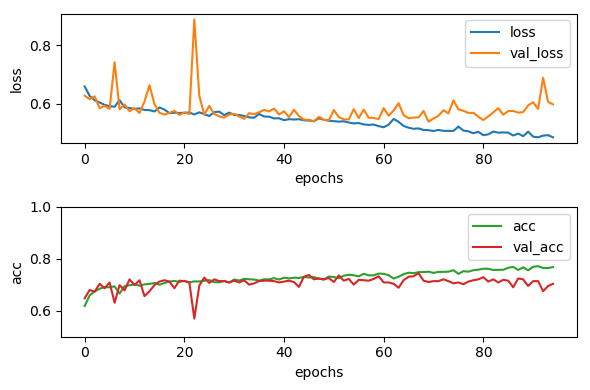

In [38]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_convLSTM.png')

In [39]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 5s 926us/step
test_loss: 0.5847 - test_acc: 0.7030


# Model \#5: Embedding + Conv1D + Pooling + LSTM

In [41]:
from keras.layers import MaxPooling1D

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(3, 2))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 701, 64)           1088      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 697, 64)           20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 348, 64)           0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
_________________________________________________________________


In [42]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 3s 620us/step - loss: 0.6574 - acc: 0.6171 - val_loss: 0.6258 - val_acc: 0.6735
Epoch 2/300
5284/5284 [==============================] - 3s 512us/step - loss: 0.6301 - acc: 0.6573 - val_loss: 0.6182 - val_acc: 0.6718
Epoch 3/300
5284/5284 [==============================] - 3s 516us/step - loss: 0.6129 - acc: 0.6713 - val_loss: 0.6031 - val_acc: 0.6837
Epoch 4/300
5284/5284 [==============================] - 3s 515us/step - loss: 0.6037 - acc: 0.6811 - val_loss: 0.6014 - val_acc: 0.6769
Epoch 5/300
5284/5284 [==============================] - 3s 517us/step - loss: 0.5954 - acc: 0.6860 - val_loss: 0.5864 - val_acc: 0.6820
Epoch 6/300
5284/5284 [==============================] - 3s 514us/step - loss: 0.5923 - acc: 0.6927 - val_loss: 0.5817 - val_acc: 0.6990
Epoch 7/300
5284/5284 [==============================] - 3s 511us/step - loss: 0.5839 - acc: 0.6966 - val_loss: 0.5772 - val_acc: 0

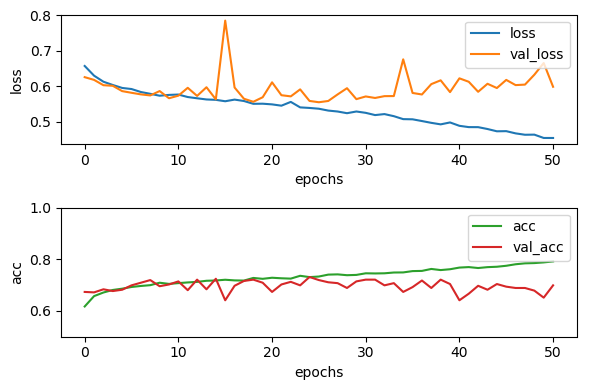

In [43]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_pool_convLSTM.png')

In [44]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 3s 534us/step
test_loss: 0.6187 - test_acc: 0.6933


# Model \#7: Embedding + BiLSTM

In [45]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 701, 64)           1088      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                25088     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 26,241
Trainable params: 26,241
Non-trainable params: 0
_________________________________________________________________


In [46]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 7s 1ms/step - loss: 0.6731 - acc: 0.5965 - val_loss: 0.6376 - val_acc: 0.6514
Epoch 2/300
5284/5284 [==============================] - 7s 1ms/step - loss: 0.6371 - acc: 0.6459 - val_loss: 0.6687 - val_acc: 0.5816
Epoch 3/300
5284/5284 [==============================] - 7s 1ms/step - loss: 0.6242 - acc: 0.6605 - val_loss: 0.6037 - val_acc: 0.6837
Epoch 4/300
5284/5284 [==============================] - 7s 1ms/step - loss: 0.6114 - acc: 0.6711 - val_loss: 0.6084 - val_acc: 0.6769
Epoch 5/300
5284/5284 [==============================] - 7s 1ms/step - loss: 0.6057 - acc: 0.6785 - val_loss: 0.5959 - val_acc: 0.6854
Epoch 6/300
5284/5284 [==============================] - 7s 1ms/step - loss: 0.5964 - acc: 0.6900 - val_loss: 0.5985 - val_acc: 0.6905
Epoch 7/300
5284/5284 [==============================] - 7s 1ms/step - loss: 0.5933 - acc: 0.6898 - val_loss: 0.5876 - val_acc: 0.7024
Epoch 8/

Epoch 61/300
5284/5284 [==============================] - 7s 1ms/step - loss: 0.5144 - acc: 0.7466 - val_loss: 0.5499 - val_acc: 0.7143
Epoch 62/300
5284/5284 [==============================] - 7s 1ms/step - loss: 0.5103 - acc: 0.7466 - val_loss: 0.5715 - val_acc: 0.7075
Epoch 63/300
5284/5284 [==============================] - 7s 1ms/step - loss: 0.5107 - acc: 0.7489 - val_loss: 0.5614 - val_acc: 0.7109


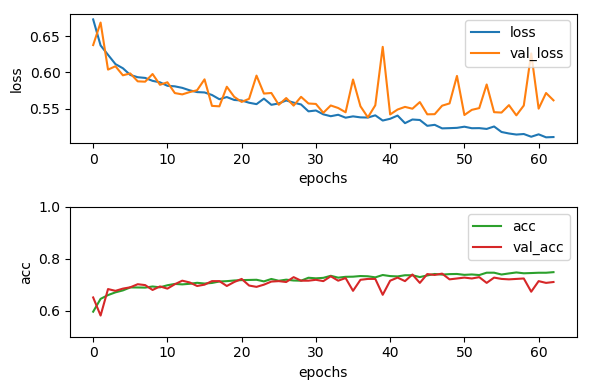

In [47]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'embedding_bilstm.png')

In [48]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 10s 2ms/step
test_loss: 0.5688 - test_acc: 0.7078


In [49]:
# model.save_weights('embedding_bilstm.h5')

# Model \#8: Embedding + Conv1D + BiLSTM

In [50]:
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(128, 10, activation='relu'))
model.add(MaxPooling1D(5, 1))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=1e-5, decay=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 701, 64)           1088      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 692, 128)          82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 688, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41472     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 124,673
Trainable params: 124,673
Non-trainable params: 0
_________________________________________________________________


In [51]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)] 

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/500
5284/5284 [==============================] - 11s 2ms/step - loss: 0.6924 - acc: 0.5079 - val_loss: 0.6914 - val_acc: 0.5153
Epoch 2/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6913 - acc: 0.5206 - val_loss: 0.6900 - val_acc: 0.5306
Epoch 3/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6902 - acc: 0.5647 - val_loss: 0.6886 - val_acc: 0.6037
Epoch 4/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6891 - acc: 0.5808 - val_loss: 0.6872 - val_acc: 0.6361
Epoch 5/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6879 - acc: 0.6011 - val_loss: 0.6857 - val_acc: 0.6412
Epoch 6/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6867 - acc: 0.6077 - val_loss: 0.6841 - val_acc: 0.6429
Epoch 7/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6855 - acc: 0.6100 - val_loss: 0.6824 - val_acc: 0.6361
Epoch 8

Epoch 61/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6350 - acc: 0.6482 - val_loss: 0.6214 - val_acc: 0.6616
Epoch 62/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6345 - acc: 0.6497 - val_loss: 0.6210 - val_acc: 0.6633
Epoch 63/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6336 - acc: 0.6476 - val_loss: 0.6206 - val_acc: 0.6667
Epoch 64/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6329 - acc: 0.6523 - val_loss: 0.6203 - val_acc: 0.6599
Epoch 65/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6321 - acc: 0.6510 - val_loss: 0.6198 - val_acc: 0.6599
Epoch 66/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6312 - acc: 0.6520 - val_loss: 0.6193 - val_acc: 0.6616
Epoch 67/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6303 - acc: 0.6539 - val_loss: 0.6189 - val_acc: 0.6633
Epoch 68/500
5284/5284 [========================

5284/5284 [==============================] - 9s 2ms/step - loss: 0.5991 - acc: 0.6870 - val_loss: 0.6022 - val_acc: 0.6701
Epoch 133/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.5996 - acc: 0.6847 - val_loss: 0.6005 - val_acc: 0.6752
Epoch 134/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.5981 - acc: 0.6866 - val_loss: 0.5997 - val_acc: 0.6820
Epoch 135/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.5987 - acc: 0.6828 - val_loss: 0.6017 - val_acc: 0.6735
Epoch 136/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.5981 - acc: 0.6894 - val_loss: 0.6033 - val_acc: 0.6667
Epoch 137/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.5991 - acc: 0.6872 - val_loss: 0.5990 - val_acc: 0.6837
Epoch 138/500
5284/5284 [==============================] - 9s 2ms/step - loss: 0.5982 - acc: 0.6874 - val_loss: 0.5996 - val_acc: 0.6786
Epoch 139/500
5284/5284 [==============================

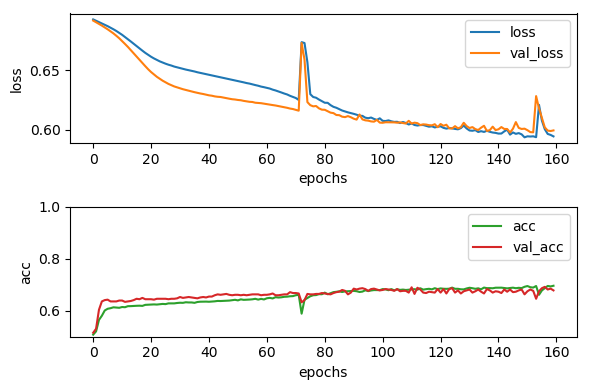

In [53]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_conv_bilstm.png')

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 11s 2ms/step
test_loss: 0.6075 - test_acc: 0.6841


# Model \#9: Embedding + Conv1D + Dense

In [55]:
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(5, 1))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 701, 64)           1088      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 697, 64)           20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 693, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 693, 64)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 44352)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 44353     
Total params: 65,985
Trainable params: 65,985
Non-trainable params: 0
_________________________________________________________________


In [56]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)]

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 2s 357us/step - loss: 0.6939 - acc: 0.5488 - val_loss: 0.6898 - val_acc: 0.5136
Epoch 2/100
5284/5284 [==============================] - 1s 280us/step - loss: 0.6498 - acc: 0.6207 - val_loss: 0.6271 - val_acc: 0.6514
Epoch 3/100
5284/5284 [==============================] - 1s 281us/step - loss: 0.6137 - acc: 0.6667 - val_loss: 0.6333 - val_acc: 0.6344
Epoch 4/100
5284/5284 [==============================] - 1s 281us/step - loss: 0.5952 - acc: 0.6860 - val_loss: 0.6160 - val_acc: 0.6446
Epoch 5/100
5284/5284 [==============================] - 1s 280us/step - loss: 0.5751 - acc: 0.6974 - val_loss: 0.6336 - val_acc: 0.6616
Epoch 6/100
5284/5284 [==============================] - 1s 280us/step - loss: 0.5537 - acc: 0.7131 - val_loss: 0.6242 - val_acc: 0.6667
Epoch 7/100
5284/5284 [==============================] - 1s 282us/step - loss: 0.5397 - acc: 0.7265 - val_loss: 0.6191 - val_acc: 0

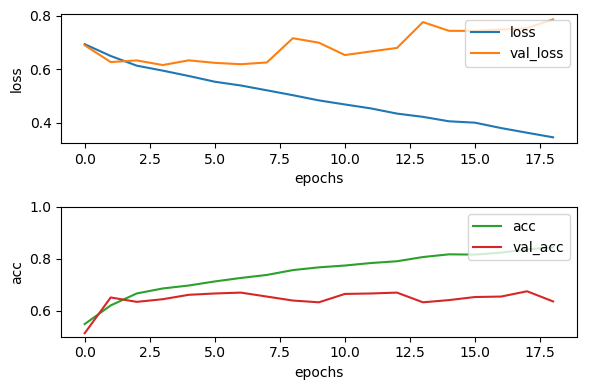

In [57]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_conv_dropout_dense.png')

In [58]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 1s 152us/step
test_loss: 0.7925 - test_acc: 0.6304


In [64]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 11s 2ms/step
test_loss: 0.6263 - test_acc: 0.6597


# Model \#: 10

In [76]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.25, dropout=0.25)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 701, 64)           1088      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 25,985
Trainable params: 25,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)] ## TODO

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 97s 18ms/step - loss: 0.6768 - acc: 0.5889 - val_loss: 0.6443 - val_acc: 0.6514
Epoch 2/100
5284/5284 [==============================] - 96s 18ms/step - loss: 0.6481 - acc: 0.6332 - val_loss: 0.6260 - val_acc: 0.6820
Epoch 3/100
5284/5284 [==============================] - 96s 18ms/step - loss: 0.6334 - acc: 0.6531 - val_loss: 0.6121 - val_acc: 0.6752
Epoch 4/100
5284/5284 [==============================] - 96s 18ms/step - loss: 0.6261 - acc: 0.6660 - val_loss: 0.6099 - val_acc: 0.6820
Epoch 5/100
5284/5284 [==============================] - 96s 18ms/step - loss: 0.6182 - acc: 0.6705 - val_loss: 0.6006 - val_acc: 0.6803
Epoch 6/100
5284/5284 [==============================] - 98s 19ms/step - loss: 0.6124 - acc: 0.6751 - val_loss: 0.6035 - val_acc: 0.6701
Epoch 7/100
5284/5284 [==============================] - 96s 18ms/step - loss: 0.6112 - acc: 0.6800 - val_loss: 0.5912 - val_acc: 0

5284/5284 [==============================] - 94s 18ms/step - loss: 0.5633 - acc: 0.7148 - val_loss: 0.5537 - val_acc: 0.7194
Epoch 61/100
5284/5284 [==============================] - 94s 18ms/step - loss: 0.5652 - acc: 0.7042 - val_loss: 0.5488 - val_acc: 0.7177
Epoch 62/100
5284/5284 [==============================] - 94s 18ms/step - loss: 0.5639 - acc: 0.7114 - val_loss: 0.5449 - val_acc: 0.7296
Epoch 63/100
5284/5284 [==============================] - 95s 18ms/step - loss: 0.5622 - acc: 0.7072 - val_loss: 0.5479 - val_acc: 0.7194
Epoch 64/100
5284/5284 [==============================] - 94s 18ms/step - loss: 0.5654 - acc: 0.7104 - val_loss: 0.5489 - val_acc: 0.7228
Epoch 65/100
5284/5284 [==============================] - 93s 18ms/step - loss: 0.5586 - acc: 0.7148 - val_loss: 0.5504 - val_acc: 0.7245
Epoch 66/100
5284/5284 [==============================] - 93s 18ms/step - loss: 0.5614 - acc: 0.7133 - val_loss: 0.5486 - val_acc: 0.7228
Epoch 67/100
5284/5284 [=======================

In [ ]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_dropout_LSTM.png')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))